# Toxic Comment Classifier

# Imports

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
import re
import html
import string

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
import mlflow 
import git 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Set-up

# Get Data

In [2]:
train = pd.read_csv('../data/train.csv', nrows = 500)

# EDA

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


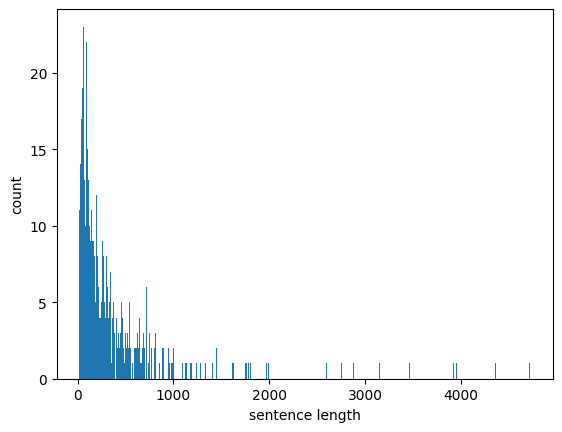

In [6]:
sentence_lengths = [len(sentence) for sentence in train['comment_text']]
plt.hist(sentence_lengths, bins = 500)
plt.xlabel('sentence length')
plt.ylabel('count')
plt.show();

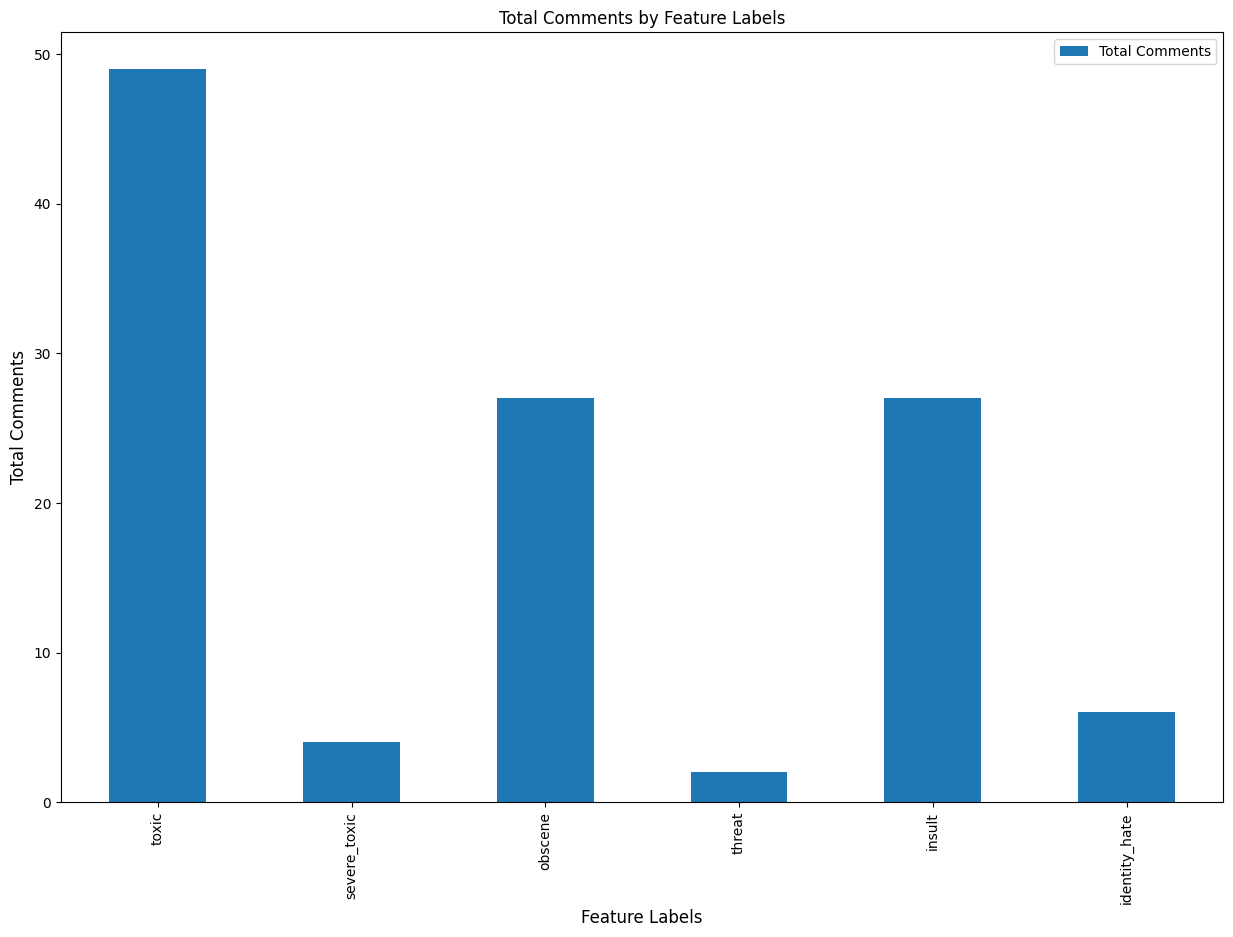

In [8]:
import matplotlib.pyplot as plt
feature = train.drop(['id', 'comment_text'], axis = 1)

counts = []
categories = list(feature.columns.values)
for i in categories:
    counts.append((i, feature[i].sum()))

df_1 = pd.DataFrame(
    counts,
    columns = ['Feature Labels', 'Total Comments']
)

df_1.plot(x = 'Feature Labels',
          y = 'Total Comments',
          kind = 'bar',
          figsize = (15, 10))
plt.title('Total Comments by Feature Labels')
plt.ylabel('Total Comments', fontsize = 12)
plt.xlabel('Feature Labels', fontsize = 12)
plt.show();

# Splitting Data

In [10]:
from sklearn.model_selection import train_test_split
X = train['comment_text']
y = train.iloc[:,2:]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Preprocessing

- Remove special chars
- Remove punctuation
- Convert to lowercase
- Replace numbers
- Tokenize text
- Remove stopwords
- Lemmatize words

In [13]:
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
class TextProcessor(BaseEstimator):
    '''
    TextProcessor preprocesses text by applying the rules and implements
    the BaseEstimator interface and can be used in sklearn pipelines.
    '''
    
    def remove_special_chars(self, text: str):
        '''
        Removes special characters from text.
        '''
        
        re1 = re.compile(r' +')
        x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
            'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
            '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
            ' @-@ ', '-').replace('\\', ' \\ ')
        return re1.sub(' ', html.unescape(x1))
    
    def remove_punctuation(self, text: str):
        '''
        Removes punctuation from text.
        '''
        
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)
    
    def to_lowercase(self, text: str):
        '''
        Converts text to lowercase.
        '''
        
        return text.lower()
    
    def remove_stopwords(self, words: str):
        '''
        Removes stopwords from text.
        '''
        
        stop_words = stopwords.words('english')
        
        return [word for word in words if word not in stop_words]
    
    def lemmatize_words(self, words):
        '''
        Lemmatizes words.
        '''
        
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in words]

    def lemmatize_verbs(self, words):
        '''
        Lemmatizes verbs.
        '''
        
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word, pos='v') for word in words]
    
    def clean_text(self, text: str):
        '''
        Cleans text.
        '''
        
        text = self.remove_special_chars(text)
        text = self.remove_punctuation(text)
        text = self.to_lowercase(text)
        text = self.replace_numbers(text)
        words = self.text2words(text)
        words = self.remove_stopwords(words)
        words = self.lemmatize_words(words)
        words = self.lemmatize_verbs(words)
        
        return ''.join(words)
    
    def fit(self, X, y=None):
        '''
        Fits the TextProcessor.
        '''
        
        return self
    
    def transform(self, X):
        '''
        Transforms the input text.
        '''
        
        return map(lambda x: self.clean_text(x), X)

# Experiment Tracking with MLFlow

In [20]:
mlflow.set_experiment('Toxic Comment Classifier')
mlflow.sklearn.autolog(silent = True)

repo = git.Repo(search_parent_directories=True)
sha_commit = repo.head.object.hexsha

KeyboardInterrupt: 

# Traning models

## 1. Bag of Words

In [ ]:
p = Pipeline([
    ('preprocessing', TextProcessor()),
    ('bow', CountVectorizer(min_df = 2, max_features = 1000)),
    ('knn', KNeighborsClassifier(n_neighbors = 6))
])

In [ ]:
mlflow.start_run()
mlflow.set_tag('mlflow.source.git.commit', sha_commit)
mlflow.set_tag('method', 'bag of words')

p.fit(X_train, y_train)
p.score(X_test, y_test)

mlflow.end_run()

KeyboardInterrupt: 

## 2. TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
p = Pipeline([
    ('preprocessig', TextProcessor()),
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df = 2, max_features=1000)),
])

In [ ]:
mlflow.start_run()
mlflow.set_tag('mlflow.source.git.commit', sha_commit)
mlflow.set_tag('method', 'tfidf')

p.fit(X_train, y_train)
p.score(X_test, y_test)

mlflow.end_run()

## 3.Word2vec

In [21]:
from gensim.models import Word2Vec
class Word2VecTransformer(BaseEstimator):
    '''
    Word2vecTransformer provides a wrapper around gensim's Word2Vec model
    to be used in scikit-learn pipelines.
    '''
    
    def __init__(self, min_count: int = 5, vector_size: int = 100,
                 window: int = 5):
        self.min_count = min_count
        self.vector_size = vector_size
        self.window = window
        self.sentences = []
    
    def fit(self, x, y=None):
        '''
        Fit the transformer to the training data.
        '''
        self.sentences = list(map(lambda k: k.split(), x))
        self.model = Word2Vec(min_count=self.min_count,
                              vector_size=self.vector_size,
                              window=self.window, sg = 1)
        self.model.build_vocab(self.sentences, progress_per=10000)
        self.model.train(self.sentences, total_examples=self.model.corpus_count,
                         epochs = 20)
        return self
    
    def transform(self, x):
        '''
        Transform the input data.
        '''
        
        sentences = list(map(lambda k: k.split(), x))
        if len(sentences) != 0:
            self.sentences = sentences
        w2v_words = list(self.model.wv.index_to_key)
        
        vector = []
        for sentence in self.sentences:
            sentence_vec = np.zeros(self.vector_size)
            count = 0
            for word in sentence:
                if word in w2v_words:
                    vec = self.model.wv[word]
                    sentence_vec += vec
                    count += 1
            if count != 0:
                sentence_vec /= count
            vector.append(sentence_vec)
        
        return vector

In [ ]:
p = Pipeline([
    ('preprocessing', TextPreprocessor()),
    ('word2vec', Word2vecTransformer()),
    ('knn', KNeighborsClassifier(n_neighbors=6))
])


In [ ]:
mlflow.start_run()
mlflow.set_tag('mlflow.source.git.commit', sha_commit)
mlflow.set_tag('method', 'word2vec')

p.fit(X_train, y_train)
p.score(X_test, y_test)

mlflow.end_run()